# Email Marketing Campaign

## Importing Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

## Import File and understanding the data

In [2]:
df=pd.read_csv('Master_data.csv')

In [3]:
df.sample(5)

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,email opened (Y-1/N-0),link clicked (Y-1/N-0)
50934,134852,short_email,personalized,13,Saturday,US,14,0,0
6422,362507,long_email,generic,4,Sunday,US,2,0,0
40188,819114,short_email,personalized,12,Tuesday,US,5,0,0
67781,450371,long_email,personalized,17,Saturday,US,8,0,0
76510,910433,short_email,personalized,11,Friday,US,1,0,0


## Preprocessing and EDA

In [4]:
df.shape

(100000, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   email_id                100000 non-null  int64 
 1   email_text              100000 non-null  object
 2   email_version           100000 non-null  object
 3   hour                    100000 non-null  int64 
 4   weekday                 100000 non-null  object
 5   user_country            100000 non-null  object
 6   user_past_purchases     100000 non-null  int64 
 7   email opened (Y-1/N-0)  100000 non-null  int64 
 8   link clicked (Y-1/N-0)  100000 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 6.9+ MB


### Checking Missing Values

In [6]:
df.isnull().sum()

email_id                  0
email_text                0
email_version             0
hour                      0
weekday                   0
user_country              0
user_past_purchases       0
email opened (Y-1/N-0)    0
link clicked (Y-1/N-0)    0
dtype: int64

#### No Missing Values are present.

In [7]:
df.describe()

,email_id,hour,user_past_purchases,email opened (Y-1/N-0),link clicked (Y-1/N-0)
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,498690.196160,9.059300,3.87845,0.103450,0.021190
std,289230.727534,4.439637,3.19611,0.304547,0.144018
min,8.000000,1.000000,0.00000,0.000000,0.000000
25%,246708.250000,6.000000,1.00000,0.000000,0.000000
50%,498447.000000,9.000000,3.00000,0.000000,0.000000
75%,749942.750000,12.000000,6.00000,0.000000,0.000000
max,999998.000000,24.000000,22.00000,1.000000,1.000000


#### Open Rate

In [8]:
total_emails = df.shape[0]
open_rate = df['email opened (Y-1/N-0)'].mean()
print(f"Open Rate: {open_rate:.2%}")

Open Rate: 10.35%


In [9]:
df.value_counts('link clicked (Y-1/N-0)')

link clicked (Y-1/N-0)
0    97881
1     2119
Name: count, dtype: int64

In [10]:
linkopen_counts = df["link clicked (Y-1/N-0)"].value_counts()
linkopen_counts/sum(df.value_counts('link clicked (Y-1/N-0)'))*100

link clicked (Y-1/N-0)
0    97.881
1     2.119
Name: count, dtype: float64

#### Current CTR

In [11]:
click_rate = df['link clicked (Y-1/N-0)'].mean()
print(f"Click-through Rate (CTR): {click_rate:.2%}")

Click-through Rate (CTR): 2.12%


The Click Through Rate (CTR) is only 2.12% which makes it a rare event. This is an unbalanced dataset

### Breakdown of CTR by Segments

#### By Email Text

In [12]:
# By email text
(df.groupby("email_text")['link clicked (Y-1/N-0)'].mean())

email_text
long_email     0.018538
short_email    0.023872
Name: link clicked (Y-1/N-0), dtype: float64

In [13]:
email_text_stats = df.groupby("email_text")[["email opened (Y-1/N-0)", "link clicked (Y-1/N-0)"]].mean().reset_index()
email_text_stats

,email_text,email opened (Y-1/N-0),link clicked (Y-1/N-0)
0,long_email,0.091177,0.018538
1,short_email,0.115860,0.023872


In [14]:
email_text_stats=email_text_stats.melt(id_vars="email_text", var_name="Metric", value_name="Rate")
email_text_stats

,email_text,Metric,Rate
0,long_email,email opened (Y-1/N-0),0.091177
1,short_email,email opened (Y-1/N-0),0.115860
2,long_email,link clicked (Y-1/N-0),0.018538
3,short_email,link clicked (Y-1/N-0),0.023872


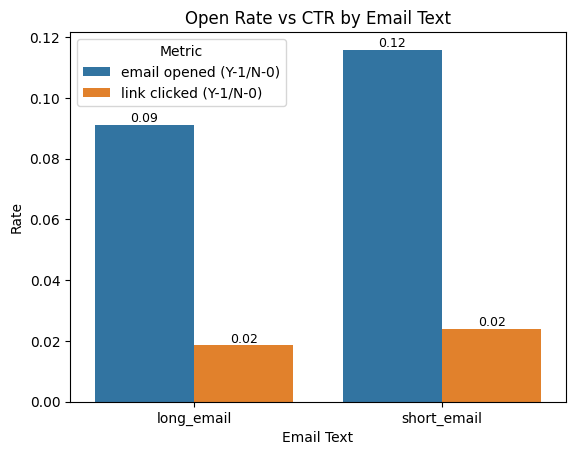

In [15]:
email_text_stats = df.groupby("email_text")[["email opened (Y-1/N-0)", "link clicked (Y-1/N-0)"]].mean().reset_index()
email_text_stats = email_text_stats.melt(id_vars="email_text", var_name="Metric", value_name="Rate")

# Plot
ax=sns.barplot(data=email_text_stats, x="email_text", y="Rate", hue="Metric")
# Add bar labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9)
plt.title("Open Rate vs CTR by Email Text")
plt.ylabel("Rate")
plt.xlabel("Email Text")
plt.show()

Short emails have a higher chance of getting opended, although CTR is same for both

In [16]:
# Group by email_text
email_text_stats = df.groupby("email_text")[["email opened (Y-1/N-0)", "link clicked (Y-1/N-0)"]].mean().reset_index()
email_text_stats

,email_text,email opened (Y-1/N-0),link clicked (Y-1/N-0)
0,long_email,0.091177,0.018538
1,short_email,0.115860,0.023872


In [17]:
#Total no. of emails sent Email Text wise
(df.groupby("email_text")['email_id'].count())/total_emails*100

email_text
long_email     50.276
short_email    49.724
Name: email_id, dtype: float64

#### By Email Version

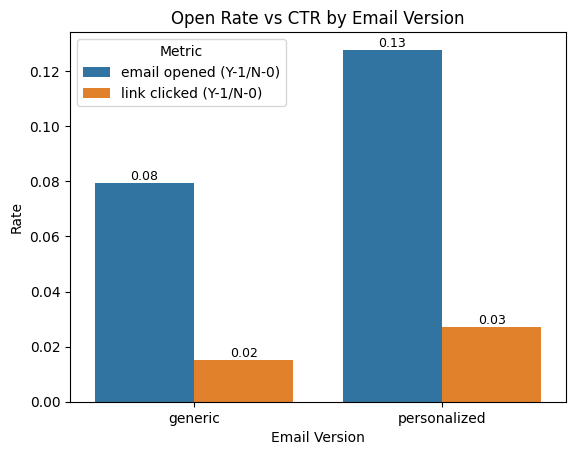

In [18]:
email_ver_stats = df.groupby("email_version")[["email opened (Y-1/N-0)", "link clicked (Y-1/N-0)"]].mean().reset_index()
email_ver_stats = email_ver_stats.melt(id_vars="email_version", var_name="Metric", value_name="Rate")

ax=sns.barplot(data=email_ver_stats, x="email_version", y="Rate", hue="Metric")
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9)
plt.title("Open Rate vs CTR by Email Version")
plt.ylabel("Rate")
plt.xlabel("Email Version")
plt.show()

Personalised emails have a higher chance of getting opended and clicked

In [19]:
#Total no. of emails sent Email Version wise
(df.groupby("email_version")['email_id'].count())/total_emails*100

email_version
generic         50.209
personalized    49.791
Name: email_id, dtype: float64

#### By Hour

In [20]:
# By hour of the day
(df.groupby("hour")['link clicked (Y-1/N-0)'].mean())*100

hour
1     1.812801
2     1.632209
3     1.952278
4     1.618641
5     1.801252
6     1.714668
7     1.828376
8     1.893308
9     2.579435
10    2.823961
11    2.712816
12    2.566073
13    1.988891
14    2.074236
15    2.490696
16    2.319681
17    1.848917
18    1.618578
19    1.657459
20    1.219512
21    0.821918
22    1.960784
23    4.137931
24    2.898551
Name: link clicked (Y-1/N-0), dtype: float64

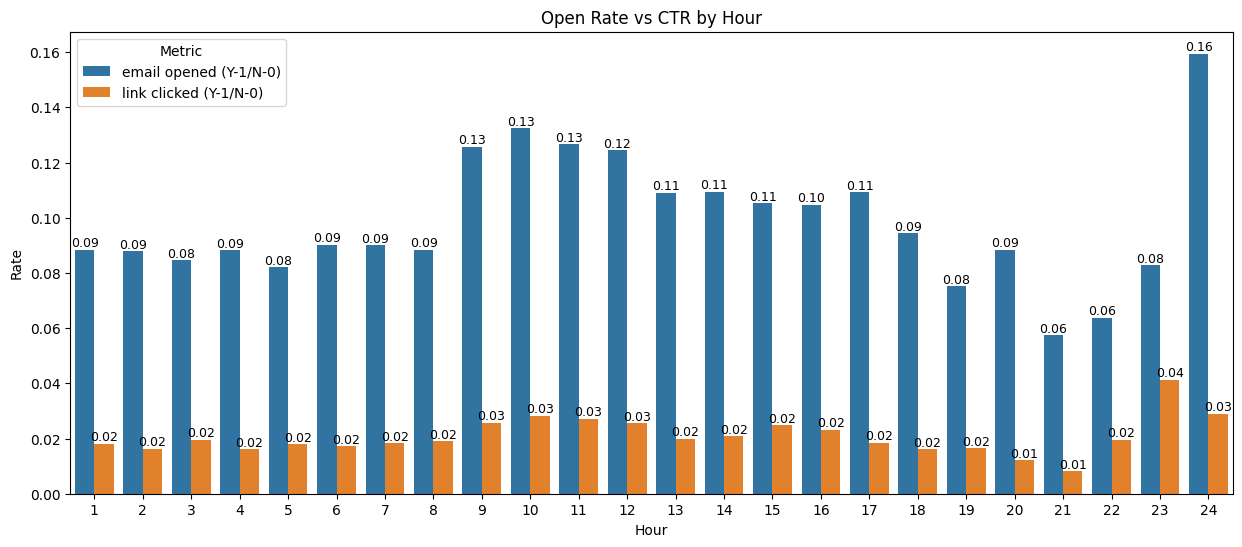

In [21]:
email_hr_stats = df.groupby("hour")[["email opened (Y-1/N-0)", "link clicked (Y-1/N-0)"]].mean().reset_index()
email_hr_stats = email_hr_stats.melt(id_vars="hour", var_name="Metric", value_name="Rate")

plt.figure(figsize=(15, 6))
ax=sns.barplot(data=email_hr_stats, x="hour", y="Rate", hue="Metric")
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9)
plt.title("Open Rate vs CTR by Hour")
plt.ylabel("Rate")
plt.xlabel("Hour")
plt.show()

Emails sent during work hours have a higher chance of getting opened and clicked. Note that at 24 hrs the bar is high as there were only 69 emails sent during that time which is quite less than the others. So we ignore it

In [22]:
#Total no. of emails sent Hour Sent wise
(df.groupby("hour")['email_id'].count())/total_emails*100

hour
1     2.703
2     3.676
3     4.610
4     5.622
5     6.551
6     7.465
7     8.204
8     8.398
9     8.529
10    8.180
11    7.483
12    6.508
13    5.581
14    4.580
15    3.493
16    2.759
17    1.893
18    1.421
19    0.905
20    0.656
21    0.365
22    0.204
23    0.145
24    0.069
Name: email_id, dtype: float64

#### By Past Purchase

In [23]:
# By past purchases
(df.groupby("user_past_purchases")['link clicked (Y-1/N-0)'].mean())*100

user_past_purchases
0       0.050443
1       1.119919
2       1.534213
3       1.656040
4       2.140929
5       2.222960
6       3.205640
7       3.073872
8       3.960847
9       4.550971
10      4.655099
11      5.602061
12      6.567797
13      6.574394
14      9.116022
15     11.702128
16     11.764706
17      8.333333
18      2.857143
19     20.000000
20      0.000000
21     50.000000
22    100.000000
Name: link clicked (Y-1/N-0), dtype: float64

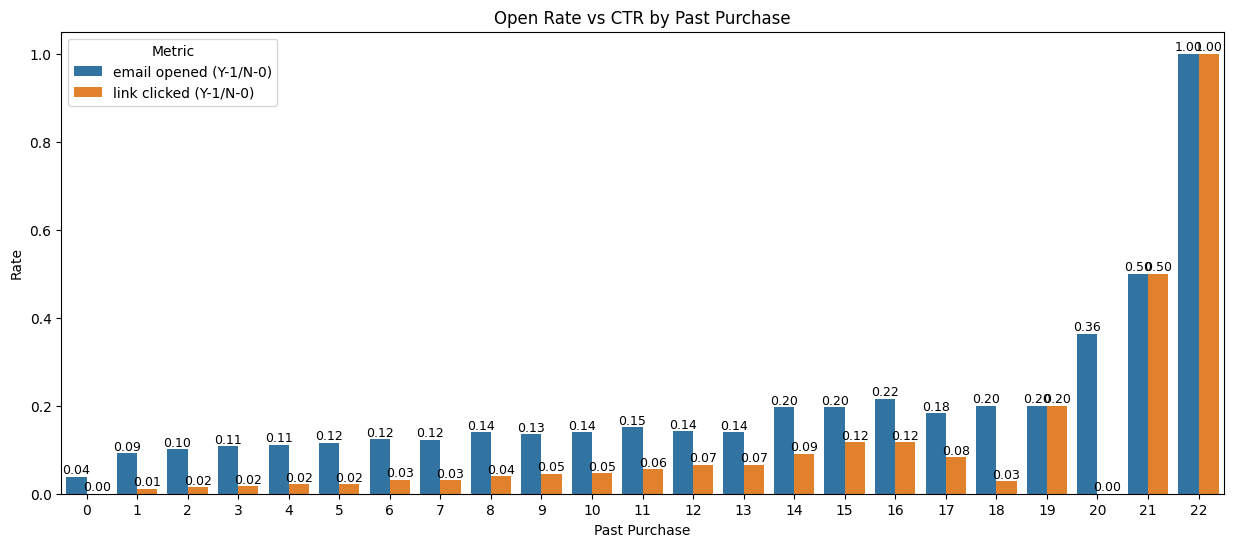

In [24]:
email_npp_stats = df.groupby("user_past_purchases")[["email opened (Y-1/N-0)", "link clicked (Y-1/N-0)"]].mean().reset_index()
email_npp_stats = email_npp_stats.melt(id_vars="user_past_purchases", var_name="Metric", value_name="Rate")

plt.figure(figsize=(15, 6))
ax=sns.barplot(data=email_npp_stats, x="user_past_purchases", y="Rate", hue="Metric")
# Adding bar labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9)
plt.title("Open Rate vs CTR by Past Purchase")
plt.ylabel("Rate")
plt.xlabel("Past Purchase")
plt.show()

Users having more than 5 past purchases show significant interest as their CTR is above average

In [25]:
#Total no. of emails sent Past Purchase wise
(df.groupby("user_past_purchases")['email_id'].count())/total_emails*100

user_past_purchases
0     13.877
1     13.751
2     13.036
3     12.077
4     10.743
5      9.042
6      7.518
7      6.051
8      4.393
9      3.296
10     2.363
11     1.553
12     0.944
13     0.578
14     0.362
15     0.188
16     0.102
17     0.060
18     0.035
19     0.015
20     0.011
21     0.004
22     0.001
Name: email_id, dtype: float64

#### By Country

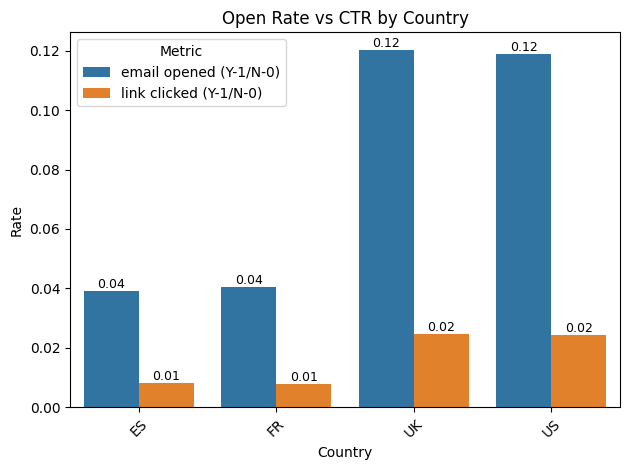

In [26]:
# CTR by Country

country_stats = (
    df.groupby("user_country")[["email opened (Y-1/N-0)", "link clicked (Y-1/N-0)"]]
    .mean()
    .reset_index()
    .melt(id_vars="user_country", var_name="Metric", value_name="Rate")
)

# Plot
ax=sns.barplot(data=country_stats, x="user_country", y="Rate", hue="Metric")
# Add bar labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9)
plt.title("Open Rate vs CTR by Country")
plt.ylabel("Rate")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Users for US and UK have higher email open rates and CTRs than Spain and France

#### By WeekDay

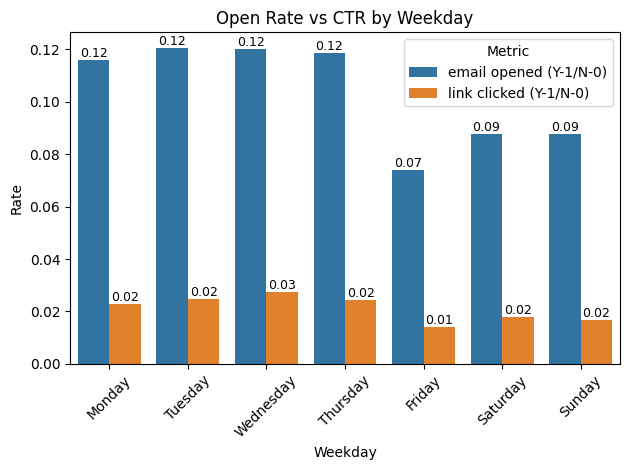

In [27]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekday_stats = (
    df.groupby("weekday")[["email opened (Y-1/N-0)", "link clicked (Y-1/N-0)"]]
    .mean()
    .reindex(weekday_order)
    .reset_index()
    .melt(id_vars="weekday", var_name="Metric", value_name="Rate")
)

# Plot
ax=sns.barplot(data=weekday_stats, x="weekday", y="Rate", hue="Metric")
# Add bar labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9)
plt.title("Open Rate vs CTR by Weekday")
plt.ylabel("Rate")
plt.xlabel("Weekday")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Sending Mails in Working days seems more effective

### One Hot Encoding

In [28]:
# Detecting categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols

['email_text', 'email_version', 'weekday', 'user_country']

In [29]:
df_encoded= pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_encoded.head()

,email_id,hour,user_past_purchases,email opened (Y-1/N-0),link clicked (Y-1/N-0),email_text_short_email,email_version_personalized,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_FR,user_country_UK,user_country_US
0,85120,2,5,0,0,True,True,False,False,True,False,False,False,False,False,True
1,966622,12,2,1,1,False,True,False,False,True,False,False,False,False,True,False
2,777221,11,2,0,0,False,True,False,False,False,False,False,True,False,False,True
3,493711,6,1,0,0,True,False,True,False,False,False,False,False,False,True,False
4,106887,14,6,0,0,False,False,True,False,False,False,False,False,False,False,True


In [30]:
data=df_encoded.drop(columns=['email_id'])

In [31]:
data.head()

,hour,user_past_purchases,email opened (Y-1/N-0),link clicked (Y-1/N-0),email_text_short_email,email_version_personalized,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_FR,user_country_UK,user_country_US
0,2,5,0,0,True,True,False,False,True,False,False,False,False,False,True
1,12,2,1,1,False,True,False,False,True,False,False,False,False,True,False
2,11,2,0,0,False,True,False,False,False,False,False,True,False,False,True
3,6,1,0,0,True,False,True,False,False,False,False,False,False,True,False
4,14,6,0,0,False,False,True,False,False,False,False,False,False,False,True


### Correlation Matrix

In [32]:
corr = data.corr()
corr

,hour,user_past_purchases,email opened (Y-1/N-0),link clicked (Y-1/N-0),email_text_short_email,email_version_personalized,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_FR,user_country_UK,user_country_US
hour,1.000000,0.002986,0.025972,0.011047,-0.001611,-0.000827,-0.000326,0.003186,0.003920,-0.004266,-0.001750,0.000743,-0.002363,-0.001930,0.002296
user_past_purchases,0.002986,1.000000,0.085934,0.105445,-0.003217,-0.001914,0.002996,0.001382,-0.006180,-0.003082,0.007193,-0.004210,0.004537,-0.005430,-0.002140
email opened (Y-1/N-0),0.025972,0.085934,1.000000,0.421750,0.040523,0.079471,0.016960,-0.021422,-0.021270,0.020090,0.022701,0.022372,-0.068750,0.027393,0.062746
link clicked (Y-1/N-0),0.011047,0.105445,0.421750,1.000000,0.018519,0.042208,0.004880,-0.009588,-0.012635,0.009223,0.010423,0.018077,-0.030511,0.012077,0.027012
email_text_short_email,-0.001611,-0.003217,0.040523,0.018519,1.000000,-0.000283,-0.002900,-0.001434,-0.002211,0.004397,0.001351,-0.001617,0.000606,-0.001675,-0.000352
email_version_personalized,-0.000827,-0.001914,0.079471,0.042208,-0.000283,1.000000,0.001968,-0.006692,0.007327,-0.000438,0.004078,-0.000032,-0.000974,0.002261,-0.002364
weekday_Monday,-0.000326,0.002996,0.016960,0.004880,-0.002900,0.001968,1.000000,-0.169122,-0.167883,-0.167133,-0.166217,-0.165813,-0.003383,0.000012,-0.000234
weekday_Saturday,0.003186,0.001382,-0.021422,-0.009588,-0.001434,-0.006692,-0.169122,1.000000,-0.169287,-0.168530,-0.167606,-0.167199,0.001590,0.002276,-0.004331
weekday_Sunday,0.003920,-0.006180,-0.021270,-0.012635,-0.002211,0.007327,-0.167883,-0.169287,1.000000,-0.167296,-0.166379,-0.165974,-0.001233,-0.000758,0.002127
weekday_Thursday,-0.004266,-0.003082,0.020090,0.009223,0.004397,-0.000438,-0.167133,-0.168530,-0.167296,1.000000,-0.165635,-0.165233,-0.002667,-0.003269,0.003833


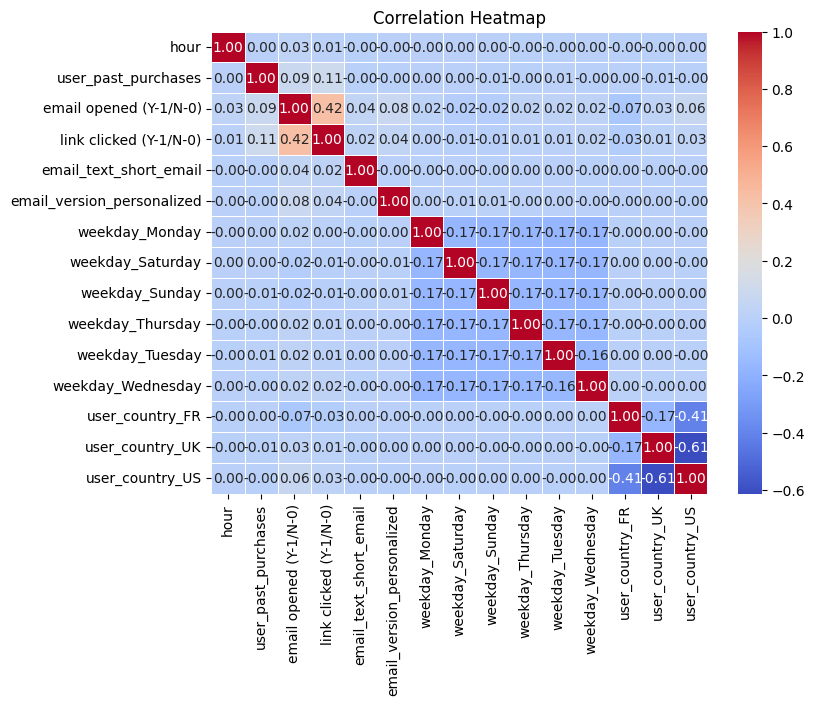

In [33]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### Feature Engineering:

Created following new features:

1. working_hours: 1 if hours lie between 9am and 6 pm,0 otherwise
2. is_weekend: 1 if the day is Saturday or Sunday,0 otherwise
3. personalized_short: 1 if the email is personalized and short, 0 otherwise

In [34]:
# Creating a copy to work on
df_fe = df.copy()

# Creating working_hours flag (1 if between 9 and 18)
df_fe['working_hours'] = df_fe['hour'].apply(lambda x: 1 if 9 <= x <= 18 else 0)

# Creating weekend flag
df_fe['is_weekend'] = df_fe['weekday'].isin(['Saturday', 'Sunday']).astype(int)

# Encoding categorical variables
from sklearn.preprocessing import LabelEncoder

# categorical_cols = ['email_text', 'email_version', 'weekday', 'user_country']
# label_encoders = {}
# for col in categorical_cols:
#     le = LabelEncoder()
#     df_fe[col] = le.fit_transform(df_fe[col])
#     label_encoders[col] = le

# Detecting categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols

df_encoded= pd.get_dummies(df_fe, columns=categorical_cols, drop_first=True).astype(int)


#Add interaction term: personalized + short email
# df_fe['personalized_short'] = ((df_fe['email_version'] == label_encoders['email_version'].transform(['personalized'])[0]) &
#                                (df_fe['email_text'] == label_encoders['email_text'].transform(['short_email'])[0])).astype(int)

df_encoded['personalized_short'] = ((df_encoded['email_text_short_email']) &
                                (df_encoded['email_version_personalized'] )).astype(int)
# df_fe.head()
df_encoded.head()

,email_id,hour,user_past_purchases,email opened (Y-1/N-0),link clicked (Y-1/N-0),working_hours,is_weekend,email_text_short_email,email_version_personalized,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_FR,user_country_UK,user_country_US,personalized_short
0,85120,2,5,0,0,0,1,1,1,0,0,1,0,0,0,0,0,1,1
1,966622,12,2,1,1,1,1,0,1,0,0,1,0,0,0,0,1,0,0
2,777221,11,2,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0
3,493711,6,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
4,106887,14,6,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0


## Modelling and Evaluation

Please Note:

1. We are highly interested in Recall than any other parameter for model evaluation. As Recall places significance on False Negatives (i.e predicting an actual click as not clicked), we want higher recall values to maximize the ROI of the marketing team

2. We cannot use email_opened as our feature as this parameter is not known while sending the emails.

### XGBoost

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Suhaditya Chakrabort\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:22:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Suhaditya Chakrabort\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Suhaditya Chakrabort\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     19547
           1       0.00      0.00      0.00       453

    accuracy                           0.98     20000
   macro avg       0.49      0.50      0.49     20000
weighted avg       0.96      0.98      0.97     20000

Confusion Matrix:
 [[19547     0]
 [  453     0]]
ROC AUC Score: 0.7281315278926402


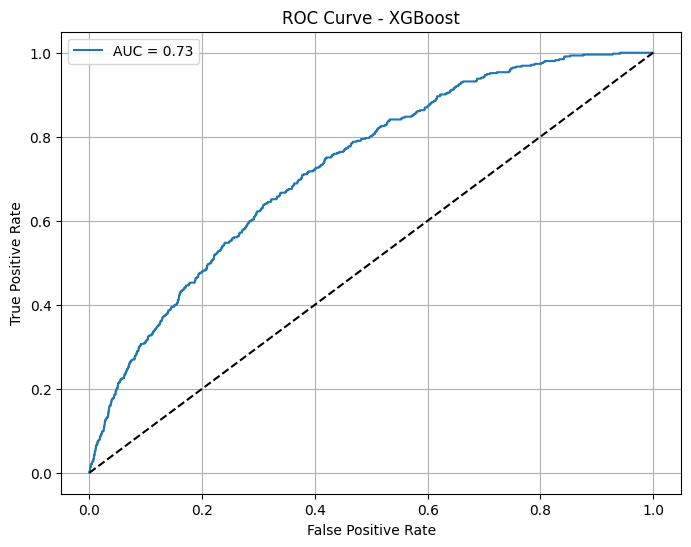

In [35]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define features and target
X = df_encoded.drop(columns=['email_id', 'link clicked (Y-1/N-0)','email opened (Y-1/N-0)'])
y = df_encoded['link clicked (Y-1/N-0)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost classifier
xgb_clf = XGBClassifier(use_label_encoder=True, eval_metric='logloss', random_state=42)

# Hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Randomized search
random_search = RandomizedSearchCV(estimator=xgb_clf,
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   scoring='roc_auc',
                                   cv=3,
                                   verbose=1,
                                   n_jobs=-1)

random_search.fit(X_train, y_train)

# Best model evaluation
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid(True)
plt.show()

The model performs very poorly. It is unable to catch no. of clicks. This may be due to imbalanced nature of the dataset

### SMOTE for Balancing + Threshold Tuning

c:\Users\Suhaditya Chakrabort\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:22:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best threshold based on F1 score: 0.61
Classification Report (After Threshold Tuning):
               precision    recall  f1-score   support

           0       0.98      0.83      0.90     19547
           1       0.04      0.29      0.07       453

    accuracy                           0.82     20000
   macro avg       0.51      0.56      0.48     20000
weighted avg       0.96      0.82      0.88     20000

Confusion Matrix:
 [[16252  3295]
 [  320   133]]
ROC AUC Score: 0.6450294535466732


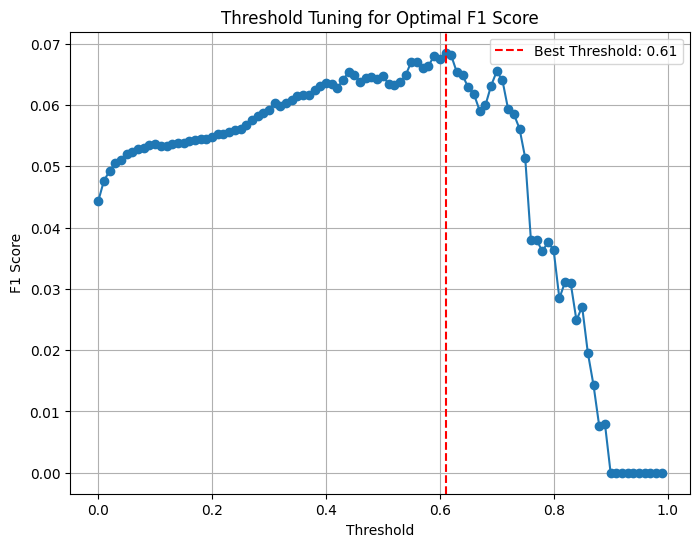

In [36]:

from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, f1_score

# Applying SMOTE to training data
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Re-training best model on resampled data
best_xgb.fit(X_resampled, y_resampled)

# Getting predicted probabilities on test set
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Tuning threshold using F1-score
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = [f1_score(y_test, y_proba > t) for t in thresholds]

# Finding best threshold
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best threshold based on F1 score: {best_threshold:.2f}")

# Prediction with optimal threshold
y_pred_optimal = (y_proba > best_threshold).astype(int)

# Re-evaluation
print("Classification Report (After Threshold Tuning):\n", classification_report(y_test, y_pred_optimal))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_optimal))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Plot F1 score vs threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, marker='o')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Threshold Tuning for Optimal F1 Score")
plt.legend()
plt.grid(True)
plt.show()


The model performs better with SMOTE but a 29% Recall value is still low. We try to improve our model

### Conditional Probability Model using LightGBM

model1=Open Probability Model

model2= Click Given Open Model

P(click)=P(open)*P(click|open)

In [37]:
from lightgbm import LGBMClassifier

#### Step 1: Model P(open)

In [38]:
# feature columns (exclude target/IDs)
feature_cols = [
    col for col in df_encoded.columns 
    if col not in ['email_id', 'link clicked (Y-1/N-0)', 'email opened (Y-1/N-0)']
]

X_open = df_encoded[feature_cols]
y_open = df_encoded['email opened (Y-1/N-0)']

X_open_train, X_open_test, y_open_train, y_open_test = train_test_split(X_open, y_open, test_size=0.2, random_state=42)

model_open = LGBMClassifier(random_state=42)
model_open.fit(X_open_train, y_open_train)

[LightGBM] [Info] Number of positive: 8253, number of negative: 71747
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.103163 -> initscore=-2.162569
[LightGBM] [Info] Start training from score -2.162569


LGBMClassifier(random_state=42)

#### Step 2: Model P(click | open)


In [39]:
df_opened = df_encoded[df_encoded['email opened (Y-1/N-0)'] == 1].copy()
X_click = df_opened[feature_cols]
y_click = df_opened['link clicked (Y-1/N-0)']

X_click_train, X_click_test, y_click_train, y_click_test = train_test_split(X_click, y_click, test_size=0.2, random_state=42)

model_click = LGBMClassifier(random_state=42)
model_click.fit(X_click_train, y_click_train)

[LightGBM] [Info] Number of positive: 1690, number of negative: 6586
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 74
[LightGBM] [Info] Number of data points in the train set: 8276, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.204205 -> initscore=-1.360218
[LightGBM] [Info] Start training from score -1.360218


LGBMClassifier(random_state=42)

#### Step 3: Predict Final P(click) = P(open) × P(click | open)

In [40]:
results_df = X_click_test.copy()
results_df['P(open)'] = model_open.predict_proba(X_click_test)[:, 1]
results_df['P(click | open)'] = model_click.predict_proba(X_click_test)[:, 1]
results_df['P(click)'] = results_df['P(open)'] * results_df['P(click | open)']

#### Top Predictions

In [41]:
# Display top predictions
results_df[['P(open)', 'P(click | open)', 'P(click)']].sort_values(by='P(click)', ascending=False).head(10)

,P(open),P(click | open),P(click)
16991,0.520854,0.757782,0.394694
48039,0.412498,0.814561,0.336005
88080,0.423258,0.684341,0.289653
29341,0.375695,0.699575,0.262827
17677,0.354781,0.716010,0.254027
64099,0.415803,0.587516,0.244291
8425,0.398332,0.523545,0.208545
62532,0.382202,0.537355,0.205378
97129,0.387143,0.503625,0.194975
63544,0.325371,0.575300,0.187186


We see that the top most P(click)=0.395, i.e. <0.5. Therefore we cannot set our threshold to 0.5. We go for threshold tuning

In [42]:
y_proba = results_df['P(click)']           # predicted probabilities
y_true = y_click_test                      # actual labels

thresholds = np.arange(0.0, 1.0, 0.01)
f1s = [f1_score(y_true, y_proba > t) for t in thresholds]
best_threshold = thresholds[np.argmax(f1s)]
print(f"Best threshold: {best_threshold:.2f}")

Best threshold: 0.03


In [43]:
y_pred = (y_proba > best_threshold).astype(int)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.62      0.72      1690
           1       0.26      0.59      0.36       379

    accuracy                           0.61      2069
   macro avg       0.56      0.60      0.54      2069
weighted avg       0.76      0.61      0.66      2069



The model has finally improved. Although the F1 score is low due to low precision , the recall has improved drastically to 0.59, i.e. the model manages to catch 59% of the users who actually clicked the link

The 3% Threshold--- P(click) > 0.03 doesn’t mean only 3% will click.
It means the model sees a signal worth betting on — and in bulk, it works.

#### Finding Average probalities of clicking the link for top 5%, 10% and 20% users

In [44]:
sorted_df=results_df[['P(open)', 'P(click | open)', 'P(click)']].sort_values(by='P(click)', ascending=False)
n=len(sorted_df)
# Calculating mean predicted CTR for top users
top_5_mean = sorted_df.head(int(0.05*n))['P(click)'].mean()
top_10_mean = sorted_df.head(int(0.1*n))['P(click)'].mean()
top_20_mean = sorted_df.head(int(0.2*n))['P(click)'].mean()

print(f"Mean P(click) for Top 5% Users: {top_5_mean:.4f}")
print(f"Mean P(click) for Top 10% Users: {top_10_mean:.4f}")
print(f"Mean P(click) for Top 20% Users: {top_20_mean:.4f}")

Mean P(click) for Top 5% Users: 0.1273
Mean P(click) for Top 10% Users: 0.1020
Mean P(click) for Top 20% Users: 0.0795


## Feature Importances

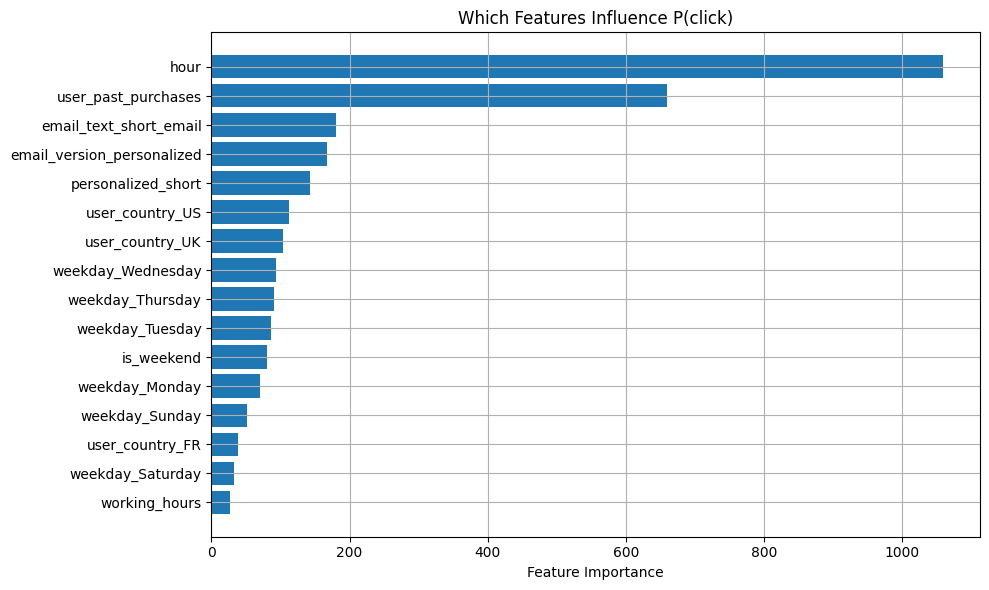

In [45]:
# feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model_click.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.title("Which Features Influence P(click)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

This shows the features we must focus on to maximize the ROI of the campaign